<a href="https://colab.research.google.com/github/wellalb/eleicao_Fortaleza/blob/main/eleicoes_presidenciais_Fortaleza_2t.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eleições presidenciais em Fortaleza-Ce - 2º turno

Este notebook apresenta o resultado das eleicões presidenciais 2º turno em Fortaleza-Ce por local de votação, as etapas a segui mostram como obter o resultado a partir dos boletins de urna (BU) e da base de eleitorado com os locais de votação disponíveis no site do TSE.

O objetivo é conseguir ver onde cada candidato se saiu melhor de acordo com a região da cidade, obtendo um nível de detalhe maior do que aquele observado no agregado por zona eleitoral.

### Mapa final - 2º turno

Pontos em tons verdes onde Bolsonaro venceu. Pontos em tons vermelhos onde Lula venceu. Quando a cor é mais escura, significa que o candidato obteve mais de 55% dos votos válidos. A cor laranja representa empate.

Clique no ponto para obter os detalhes.

In [ ]:
!pip install pandas
!pip install geopandas
!pip install matplotlib
!pip install zipfile36
!pip install shutils
!pip install requests
!pip install bytesbufio
!pip install os-sys

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.6 MB 4.9 MB/s 
     |████████████████████████████████| 594 kB 48.8 MB/s 
     |████████████████████████████████| 10.2 MB 58.2 MB/s 
     |███████████████████████████

## Procedimento

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import zipfile
import shutil
import requests
from io import BytesIO
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Boletins de urna

Base dos boletins de urna (BU) do TSE para a Fortaleza, disponível em https://dadosabertos.tse.jus.br/dataset/resultados-2022-boletim-de-urna.

In [ ]:
#df = pd.read_csv('/content/bweb_2t_CE_311020221535.csv', encoding='latin-1', sep=';')


In [ ]:
df = pd.read_csv('/content/bweb_2t_CE_311020221535.csv',encoding='ISO-8859-1', sep=';')

df.head()

,DT_GERACAO,HH_GERACAO,ANO_ELEICAO,CD_TIPO_ELEICAO,NM_TIPO_ELEICAO,CD_PLEITO,DT_PLEITO,NR_TURNO,CD_ELEICAO,DS_ELEICAO,...,CD_FLASHCARD_URNA_EFETIVADA,DT_CARGA_URNA_EFETIVADA,DS_CARGO_PERGUNTA_SECAO,DS_AGREGADAS,DT_ABERTURA,DT_ENCERRAMENTO,QT_ELEITORES_BIOMETRIA_NH,DT_EMISSAO_BU,NR_JUNTA_APURADORA,NR_TURMA_APURADORA
0,31/10/2022,15:49:18,2022,0,Eleição Ordinária,407,30/10/2022,2,545,Eleição Geral Federal 2022,...,1A8195DE,29/10/2022 12:07:00,1 - 33,#NULO#,30/10/2022 08:00:01,30/10/2022 17:01:06,18,30/10/2022 17:03:54,-1,-1
1,31/10/2022,15:49:18,2022,0,Eleição Ordinária,407,30/10/2022,2,545,Eleição Geral Federal 2022,...,1A8195DE,29/10/2022 12:07:00,1 - 33,#NULO#,30/10/2022 08:00:01,30/10/2022 17:01:06,18,30/10/2022 17:03:54,-1,-1
2,31/10/2022,15:49:18,2022,0,Eleição Ordinária,407,30/10/2022,2,545,Eleição Geral Federal 2022,...,1A8195DE,29/10/2022 12:07:00,1 - 33,#NULO#,30/10/2022 08:00:01,30/10/2022 17:01:06,18,30/10/2022 17:03:54,-1,-1
3,31/10/2022,15:49:18,2022,0,Eleição Ordinária,407,30/10/2022,2,545,Eleição Geral Federal 2022,...,1A8195DE,29/10/2022 12:07:00,1 - 33,#NULO#,30/10/2022 08:00:01,30/10/2022 17:01:06,18,30/10/2022 17:03:54,-1,-1
4,31/10/2022,15:49:18,2022,0,Eleição Ordinária,407,30/10/2022,2,545,Eleição Geral Federal 2022,...,1A8195DE,21/09/2022 10:09:00,1 - 34,#NULO#,30/10/2022 08:00:01,30/10/2022 17:01:37,30,30/10/2022 17:03:18,-1,-1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88629 entries, 0 to 88628
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   DT_GERACAO                   88629 non-null  object 
 1   HH_GERACAO                   88629 non-null  object 
 2   ANO_ELEICAO                  88629 non-null  int64  
 3   CD_TIPO_ELEICAO              88629 non-null  int64  
 4   NM_TIPO_ELEICAO              88629 non-null  object 
 5   CD_PLEITO                    88629 non-null  int64  
 6   DT_PLEITO                    88629 non-null  object 
 7   NR_TURNO                     88629 non-null  int64  
 8   CD_ELEICAO                   88629 non-null  int64  
 9   DS_ELEICAO                   88629 non-null  object 
 10  SG_UF                        88629 non-null  object 
 11  CD_MUNICIPIO                 88629 non-null  int64  
 12  NM_MUNICIPIO                 88629 non-null  object 
 13  NR_ZONA         

Filtra apenas algumas colunas de interesse, cidade de João Pessoa e eleição presidencial.

In [ ]:
df = df[df['NM_MUNICIPIO'] == 'FORTALEZA']
df = df[df['DS_ELEICAO'] == 'Eleição Geral Federal 2022']
df = df[['NR_ZONA', 'NR_SECAO', 'NM_VOTAVEL', 'QT_VOTOS', 'QT_APTOS', 'QT_COMPARECIMENTO', 'QT_ABSTENCOES']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20767 entries, 0 to 83123
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   NR_ZONA            20767 non-null  int64 
 1   NR_SECAO           20767 non-null  int64 
 2   NM_VOTAVEL         20767 non-null  object
 3   QT_VOTOS           20767 non-null  int64 
 4   QT_APTOS           20767 non-null  int64 
 5   QT_COMPARECIMENTO  20767 non-null  int64 
 6   QT_ABSTENCOES      20767 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [ ]:
!pip install pyshp
!pip install jsonlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.4 MB/s 
  ERROR: Failed building wheel for jsonlib
  Running setup.py clean for jsonlib
Failed to build jsonlib
    Running setup.py install for jsonlib ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-tqvmmmzx/jsonlib_52c9dc18a91743ef88f66b679f5c4c37/setup.py'"'"'; __file__='"'"'/tmp/pip-install-tqvmmmzx/jsonlib_52c9dc18a91743ef88f66b679f5c4c37/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(c

### Locais de votação

Carrega a base de locais de votação do TSE para o Brasil, disponível em https://dadosabertos.tse.jus.br/dataset/eleitorado-atual.

In [ ]:
#bairros = gpd.read_file('https://raw.githubusercontent.com/wellalb/eleicoes_2022_Fort-Ce/main/Limites_Territoriais.geojson')
bairros = gpd.read_file('https://raw.githubusercontent.com/wellalb/eleicoes_2022_Fort-Ce/main/bairros_Fortaleza.geojson')
bairros = bairros.drop(columns=['NOME', 'GID', 'TAREAkm', 'DESCRICAO'])
bairros.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   TAREAha    121 non-null    float64 
 1   TAREAm     121 non-null    float64 
 2   FONTE      121 non-null    object  
 3   ANO_REF    121 non-null    int64   
 4   TSAUD      121 non-null    int64   
 5   TCONS      121 non-null    int64   
 6   TCRAS      121 non-null    int64   
 7   TPRAC      121 non-null    int64   
 8   TARENI     121 non-null    int64   
 9   TEDUC      121 non-null    int64   
 10  TTOMB      121 non-null    int64   
 11  regionais  121 non-null    object  
 12  geometry   121 non-null    geometry
dtypes: float64(2), geometry(1), int64(8), object(2)
memory usage: 12.4+ KB


In [ ]:
ldf = pd.read_csv('/content/eleitorado_local_votacao_ATUAL.csv',encoding='ISO-8859-1', sep=';', error_bad_lines=False)
ldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70931 entries, 0 to 70930
Data columns (total 38 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DT_GERACAO                    70931 non-null  object 
 1   HH_GERACAO                    70931 non-null  object 
 2   AA_ELEICAO                    70931 non-null  int64  
 3   DT_ELEICAO                    0 non-null      float64
 4   DS_ELEICAO                    70931 non-null  object 
 5   NR_TURNO                      70931 non-null  int64  
 6   SG_UF                         70930 non-null  object 
 7   CD_MUNICIPIO                  70930 non-null  float64
 8   NM_MUNICIPIO                  70930 non-null  object 
 9   NR_ZONA                       70930 non-null  float64
 10  NR_SECAO                      70930 non-null  float64
 11  CD_TIPO_SECAO_AGREGADA        70930 non-null  float64
 12  DS_TIPO_SECAO_AGREGADA        70930 non-null  object 
 13  N

Seleciona na base de locais de votação apenas o município de João Pessoa e alguns campos de interesse.

In [ ]:
ldf = ldf[ldf['NM_MUNICIPIO'] == 'FORTALEZA']
ldf = ldf[['NM_BAIRRO', 'NR_LATITUDE', 'NR_LONGITUDE', 'NR_ZONA', 'NR_SECAO', 'NR_LOCAL_VOTACAO', 'NM_LOCAL_VOTACAO']]

In [ ]:
ldf.head()

,NM_BAIRRO,NR_LATITUDE,NR_LONGITUDE,NR_ZONA,NR_SECAO,NR_LOCAL_VOTACAO,NM_LOCAL_VOTACAO
76,IPES,-7.105861,-34.858250,1,155,1457,ESC ESTADUAL MONS PEDRO ANISIO BEZERRA
124,FUNCIONARIOS II,-7.182127,-34.881353,77,171,1368,ESCOLA ESTADUAL JOSÉ DO PATROCINIO
197,MANGABEIRA I,-7.169732,-34.841285,70,166,1350,ESCOLA ESTADUAL DE 1 GRAU PEDRO LINS VIEIRA DE...
266,CENTRO,-7.115360,-34.883176,1,6,1040,FAC. CIÊNCIAS MÉDICAS (ANTIGO COLÉGIO PIO XII)
597,MANGABEIRA II,-7.178120,-34.839369,70,443,1929,ESCOLA ESTADUAL DE ENSINO FUNDAMENTAL JOÃO ROB...


### Associando as coordenadas dos locais de votação ao resultado dos boletins de urna

Fazendo um join entre as bases usando a zona e a seção como chave.

In [ ]:
ldf = ldf.set_index(['NR_ZONA', 'NR_SECAO'])
df = df.set_index(['NR_ZONA', 'NR_SECAO'])
df = df.join(ldf, lsuffix='', rsuffix='__LOCAL')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20767 entries, (1, 33) to (118, 675)
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NM_VOTAVEL         20767 non-null  object 
 1   QT_VOTOS           20767 non-null  int64  
 2   QT_APTOS           20767 non-null  int64  
 3   QT_COMPARECIMENTO  20767 non-null  int64  
 4   QT_ABSTENCOES      20767 non-null  int64  
 5   NM_BAIRRO          2950 non-null   object 
 6   NR_LATITUDE        2950 non-null   float64
 7   NR_LONGITUDE       2950 non-null   float64
 8   NR_LOCAL_VOTACAO   2950 non-null   float64
 9   NM_LOCAL_VOTACAO   2950 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 1.7+ MB


In [ ]:
df['NM_BAIRRO'].unique()

array([nan, 'ALDEOTA', 'VARJOTA', 'CIDADE 2000', 'CAIS DO PORTO',
       'MEIRELES', 'VICENTE PINZON', 'PRAIA DO FUTURO II', 'MUCURIPE',
       'PAPICU', 'DE LOURDES', 'PAUPINA', 'MESSEJANA', 'GUAJERU',
       'LAGOA REDONDA', 'CAMBEBA', 'COAÇU', 'JOSÉ DE ALENCAR',
       'JACARECANGA', 'CENTRO', 'PRAIA DE IRACEMA', 'ALTO DA BALANÇA',
       'DIONISIO TORRES', 'TAUAPE', 'VILA UNIÃO', 'FÁTIMA', 'AEROLÂNDIA',
       'JOAQUIM TÁVORA', 'JOSÉ BONIFÁCIO', 'SÃO GERARDO', 'ÁLVARO WEYNE',
       'CARLITO PAMPLONA', 'CRISTO REDENTOR', 'MONTE CASTELO', 'PIRAMBU',
       'BELA VISTA', 'DEMOCRITO ROCHA', 'DOM LUSTOSA', 'HENRIQUE JORGE',
       'JÓQUEI CLUBE', 'JOÃO XXIII', 'PANAMERICANO', 'PICI',
       'ANTÔNIO BEZERRA', 'AUTRAN NUNES', 'CONJUNTO CEARÁ I', 'GENIBAÚ',
       'MONDUBIM', 'PREFEITO JOSÉ WALTER', 'PLANALTO AYRTON SENNA',
       'VILA VELHA', 'QUINTINO CUNHA', 'JARDIM IRACEMA',
       'JARDIM GUANABARA', 'PADRE ANDRADE', 'BARROSO',
       'CONJUNTO PALMEIRAS', 'JANGURUSSU', 'PARQUE SAN

Salvando o resultado parcial até então.

In [ ]:
df.to_csv('eleicao_presidencial_2022_fortaleza_2_turno.csv', sep=';', encoding='utf-8')

### Base de bairros

Carregando a base de bairros de João Pessoa do repositório geodata-jp.

In [ ]:
#Baixe a base de: https://mapas.fortaleza.ce.gov.br/#/
bairros = gpd.read_file('https://raw.githubusercontent.com/wellalb/eleicoes_2022_Fort-Ce/main/shape_do_mapa.geojson')
#bairros = gpd.read_file('/content/vw_Iplanfor_BairrosFortaleza_17_08_2018.csv', sep=';', encoding='utf-8')
bairros.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   GID        121 non-null    object  
 1   NOME       121 non-null    object  
 2   DESCRICAO  121 non-null    object  
 3   TAREAha    121 non-null    float64 
 4   TAREAm     121 non-null    float64 
 5   TAREAkm    121 non-null    float64 
 6   FONTE      121 non-null    object  
 7   ANO_REF    121 non-null    int64   
 8   TSAUD      121 non-null    int64   
 9   TCONS      121 non-null    int64   
 10  TCRAS      121 non-null    int64   
 11  TPRAC      121 non-null    int64   
 12  TARENI     121 non-null    int64   
 13  TEDUC      121 non-null    int64   
 14  TTOMB      121 non-null    int64   
 15  regionais  121 non-null    object  
 16  geometry   121 non-null    geometry
dtypes: float64(3), geometry(1), int64(8), object(5)
memory usage: 16.2+ KB


In [ ]:
bairros = bairros.drop(columns=['perimetro', 'area', 'hectares', 'densidade'])

KeyError: ignored

In [ ]:
bairros.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   GID        121 non-null    object  
 1   NOME       121 non-null    object  
 2   DESCRICAO  121 non-null    object  
 3   TAREAha    121 non-null    float64 
 4   TAREAm     121 non-null    float64 
 5   TAREAkm    121 non-null    float64 
 6   FONTE      121 non-null    object  
 7   ANO_REF    121 non-null    int64   
 8   TSAUD      121 non-null    int64   
 9   TCONS      121 non-null    int64   
 10  TCRAS      121 non-null    int64   
 11  TPRAC      121 non-null    int64   
 12  TARENI     121 non-null    int64   
 13  TEDUC      121 non-null    int64   
 14  TTOMB      121 non-null    int64   
 15  regionais  121 non-null    object  
 16  geometry   121 non-null    geometry
dtypes: float64(3), geometry(1), int64(8), object(5)
memory usage: 16.2+ KB


Converção para um sistema de coordenadas métrico mais adequando.

In [ ]:
bairros = bairros.to_crs('EPSG:31985')

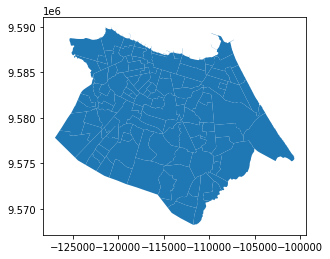

In [ ]:
bairros.plot()

### Votos válidos

Os votos válidos são computados se excluindo os votos brancos e nulos.

In [ ]:
df = df.query('NM_VOTAVEL not in ("Branco", "Nulo")')
df['NM_VOTAVEL'].unique()

array(['JAIR BOLSONARO', 'LULA'], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10470 entries, (1, 33) to (118, 675)
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NM_VOTAVEL         10470 non-null  object 
 1   QT_VOTOS           10470 non-null  int64  
 2   QT_APTOS           10470 non-null  int64  
 3   QT_COMPARECIMENTO  10470 non-null  int64  
 4   QT_ABSTENCOES      10470 non-null  int64  
 5   NM_BAIRRO          1482 non-null   object 
 6   NR_LATITUDE        1482 non-null   float64
 7   NR_LONGITUDE       1482 non-null   float64
 8   NR_LOCAL_VOTACAO   1482 non-null   float64
 9   NM_LOCAL_VOTACAO   1482 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 889.0+ KB


### Tratando valores nulos

Vamos tratar os valores NaN.

In [ ]:
df[df['NM_BAIRRO'].isnull()]

NM_VOTAVEL  QT_VOTOS  QT_APTOS  QT_COMPARECIMENTO  \
NR_ZONA NR_SECAO                                                          
1       33        JAIR BOLSONARO       184       436                342   
        33                  LULA       147       436                342   
        34                  LULA       161       455                354   
        34        JAIR BOLSONARO       186       455                354   
        35                  LULA       158       455                352   
...                          ...       ...       ...                ...   
118     671                 LULA       178       380                329   
        672                 LULA       114       214                198   
        672       JAIR BOLSONARO        81       214                198   
        675                 LULA        39        67                 50   
        675       JAIR BOLSONARO         9        67                 50   

                  QT_ABSTENCOES NM_BAIRRO  NR_LATITUDE  NR_LONGITUDE  \
NR_ZONA NR_SECAO                                                       
1       33                   94       NaN          NaN           NaN   
        33                   94       NaN          NaN           NaN   
        34                  101       NaN          NaN           NaN   
        34                  101       NaN          NaN           NaN   
        35                  103       NaN          NaN           NaN   
...                         ...       ...          ...           ...   
118     671                  51       NaN          NaN           NaN   
        672                  16       NaN          NaN           NaN   
        672                  16       NaN          NaN           NaN   
        675                  17       NaN          NaN           NaN   
        675                  17       NaN          NaN           NaN   

                  NR_LOCAL_VOTACAO NM_LOCAL_VOTACAO  
NR_ZONA NR_SECAO                                     
1       33                     NaN              NaN  
        33                     NaN              NaN  
        34                     NaN              NaN  
        34                     NaN              NaN  
        35                     NaN              NaN  
...                            ...              ...  
118     671                    NaN              NaN  
        672                    NaN              NaN  
        672                    NaN              NaN  
        675                    NaN              NaN  
        675                    NaN              NaN  

[8988 rows x 10 columns]

Fiz uma pesquisa rápida e não encontrei. Vamos seguir como `NÃO IDENTIFICADO`.

In [ ]:
df = df.fillna(value={'NM_LOCAL_VOTACAO': 'NÃO IDENTIFICADO'})

### Resultado por local de votação e candidato

Vamos agrupar por local de votação e candidato.

In [ ]:
df1 = df.groupby(['NM_LOCAL_VOTACAO', 'NM_VOTAVEL']).agg({'QT_VOTOS': 'sum'})
df1

QT_VOTOS
NM_LOCAL_VOTACAO                      NM_VOTAVEL              
ACADEMIA DO PROFESSOR DARCY RIBEIRO   JAIR BOLSONARO       224
                                      LULA                 289
ANEXO EEFM ALMIRANTE TAMANDARÉ        JAIR BOLSONARO       301
                                      LULA                 374
ANTIGA FIC / ESTÁCIO MOREIRA CAMPOS   JAIR BOLSONARO       260
...                                                        ...
UNIFAMETRO - CAMPUS PADRE IBIAPINA    LULA                 120
UNIVERSIDADE DE FORTALEZA - UNIFOR    JAIR BOLSONARO       353
                                      LULA                 437
UNIVERSIDADE ESTADUAL DO CEARA - UECE JAIR BOLSONARO       325
                                      LULA                 562

[868 rows x 1 columns]

Vamos comparar nossos resultados com o site de notícias UOL. Segundo o UOL, Fortaleza (CE): como ficou a apuração na cidade para presidente no 2º turno (em votos válidos)

*Lula (PT) - 880.559 votos - 58,18%*

*Jair Bolsonaro (PL) - 633.009 votos - 41,82%*


Disponível em https://noticias.uol.com.br/eleicoes/2022/10/30/fortaleza-ce-veja-votos-de-lula-e-bolsonaro-na-cidade-no-2-turno.htm

In [ ]:
votos_por_candidato = df1.groupby(level=1).sum()
votos_por_candidato

,QT_VOTOS
NM_VOTAVEL,
JAIR BOLSONARO,633009
LULA,880559


In [ ]:
votos_por_candidato['PERCENTUAL'] = votos_por_candidato['QT_VOTOS'] / votos_por_candidato['QT_VOTOS'].sum()
votos_por_candidato.sort_values('QT_VOTOS', ascending=False)

,QT_VOTOS,PERCENTUAL
NM_VOTAVEL,,
LULA,880559,0.581777
JAIR BOLSONARO,633009,0.418223


É isso, confere.

Agora, por local de votação.

In [ ]:
df1 = df1.unstack()
df1

QT_VOTOS     
NM_VOTAVEL                                         JAIR BOLSONARO LULA
NM_LOCAL_VOTACAO                                                      
ACADEMIA DO PROFESSOR DARCY RIBEIRO                           224  289
ANEXO EEFM ALMIRANTE TAMANDARÉ                                301  374
ANTIGA FIC / ESTÁCIO MOREIRA CAMPOS                           260  250
APAE - CENTRO DE ATENDIMENTO EDUC ESPEC MA REGI...            340  391
ASSEMBLÉIA LEGISLATIVA - UNIVERSIDADE DO PARLAM...            128  142
...                                                           ...  ...
SENAI - CENTRO DE FORMAÇÃO PROFISSIONAL                       118  165
SENAI - UNIDADE JACARECANGA                                   171  268
UNIFAMETRO - CAMPUS PADRE IBIAPINA                             86  120
UNIVERSIDADE DE FORTALEZA - UNIFOR                            353  437
UNIVERSIDADE ESTADUAL DO CEARA - UECE                         325  562

[434 rows x 2 columns]

Preciso obter as coordenadas dos locais.

In [ ]:
df2 = df.groupby(['NM_LOCAL_VOTACAO']).agg({'NR_LATITUDE': 'mean', 'NR_LONGITUDE': 'mean'})

In [ ]:
df2

,NR_LATITUDE,NR_LONGITUDE
NM_LOCAL_VOTACAO,,
ACADEMIA DO PROFESSOR DARCY RIBEIRO,-3.732985,-38.519954
ANEXO EEFM ALMIRANTE TAMANDARÉ,-3.838474,-38.516635
ANTIGA FIC / ESTÁCIO MOREIRA CAMPOS,-3.742608,-38.501558
APAE - CENTRO DE ATENDIMENTO EDUC ESPEC MA REGINA PIO DE ALMEIDA,-3.739336,-38.523871
ASSEMBLÉIA LEGISLATIVA - UNIVERSIDADE DO PARLAMENTO CEARENSE,-3.750829,-38.501984
...,...,...
SENAI - CENTRO DE FORMAÇÃO PROFISSIONAL,-3.707215,-38.584885
SENAI - UNIDADE JACARECANGA,-3.726382,-38.540661
UNIFAMETRO - CAMPUS PADRE IBIAPINA,-3.726022,-38.540487


Vamos unir os dois dataframes para chegar a uma base agregada por local de votação com as coordenadas e os votos dos candidatos pivotados para colunas.

In [ ]:
result = df2.join(df1, lsuffix='COORD_', rsuffix='QT_VOTOS_')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9138: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  sort=sort,


In [ ]:
result = result.reset_index()
result

,NM_LOCAL_VOTACAO,NR_LATITUDE,NR_LONGITUDE,"(QT_VOTOS, JAIR BOLSONARO)","(QT_VOTOS, LULA)"
0,ACADEMIA DO PROFESSOR DARCY RIBEIRO,-3.732985,-38.519954,224,289
1,ANEXO EEFM ALMIRANTE TAMANDARÉ,-3.838474,-38.516635,301,374
2,ANTIGA FIC / ESTÁCIO MOREIRA CAMPOS,-3.742608,-38.501558,260,250
3,APAE - CENTRO DE ATENDIMENTO EDUC ESPEC MA REG...,-3.739336,-38.523871,340,391
4,ASSEMBLÉIA LEGISLATIVA - UNIVERSIDADE DO PARLA...,-3.750829,-38.501984,128,142
...,...,...,...,...,...
429,SENAI - CENTRO DE FORMAÇÃO PROFISSIONAL,-3.707215,-38.584885,118,165
430,SENAI - UNIDADE JACARECANGA,-3.726382,-38.540661,171,268
431,UNIFAMETRO - CAMPUS PADRE IBIAPINA,-3.726022,-38.540487,86,120
432,UNIVERSIDADE DE FORTALEZA - UNIFOR,-3.771319,-38.480984,353,437


Calcular os votos válidos por local de votação.

In [ ]:
result['QT_VOTOS_VALIDOS'] = result.iloc[:, 3:].sum(axis=1)
result

,NM_LOCAL_VOTACAO,NR_LATITUDE,NR_LONGITUDE,"(QT_VOTOS, JAIR BOLSONARO)","(QT_VOTOS, LULA)",QT_VOTOS_VALIDOS
0,ACADEMIA DO PROFESSOR DARCY RIBEIRO,-3.732985,-38.519954,224,289,513
1,ANEXO EEFM ALMIRANTE TAMANDARÉ,-3.838474,-38.516635,301,374,675
2,ANTIGA FIC / ESTÁCIO MOREIRA CAMPOS,-3.742608,-38.501558,260,250,510
3,APAE - CENTRO DE ATENDIMENTO EDUC ESPEC MA REG...,-3.739336,-38.523871,340,391,731
4,ASSEMBLÉIA LEGISLATIVA - UNIVERSIDADE DO PARLA...,-3.750829,-38.501984,128,142,270
...,...,...,...,...,...,...
429,SENAI - CENTRO DE FORMAÇÃO PROFISSIONAL,-3.707215,-38.584885,118,165,283
430,SENAI - UNIDADE JACARECANGA,-3.726382,-38.540661,171,268,439
431,UNIFAMETRO - CAMPUS PADRE IBIAPINA,-3.726022,-38.540487,86,120,206
432,UNIVERSIDADE DE FORTALEZA - UNIFOR,-3.771319,-38.480984,353,437,790


In [ ]:
result['LULA'] = result[('QT_VOTOS', 'LULA')]
result['BOLSONARO'] = result[('QT_VOTOS', 'JAIR BOLSONARO')]

In [ ]:
result = result[['NM_LOCAL_VOTACAO', 'NR_LATITUDE', 'NR_LONGITUDE', 'LULA', 'BOLSONARO', 'QT_VOTOS_VALIDOS']]

In [ ]:
result

,NM_LOCAL_VOTACAO,NR_LATITUDE,NR_LONGITUDE,LULA,BOLSONARO,QT_VOTOS_VALIDOS
0,ACADEMIA DO PROFESSOR DARCY RIBEIRO,-3.732985,-38.519954,289,224,513
1,ANEXO EEFM ALMIRANTE TAMANDARÉ,-3.838474,-38.516635,374,301,675
2,ANTIGA FIC / ESTÁCIO MOREIRA CAMPOS,-3.742608,-38.501558,250,260,510
3,APAE - CENTRO DE ATENDIMENTO EDUC ESPEC MA REG...,-3.739336,-38.523871,391,340,731
4,ASSEMBLÉIA LEGISLATIVA - UNIVERSIDADE DO PARLA...,-3.750829,-38.501984,142,128,270
...,...,...,...,...,...,...
429,SENAI - CENTRO DE FORMAÇÃO PROFISSIONAL,-3.707215,-38.584885,165,118,283
430,SENAI - UNIDADE JACARECANGA,-3.726382,-38.540661,268,171,439
431,UNIFAMETRO - CAMPUS PADRE IBIAPINA,-3.726022,-38.540487,120,86,206
432,UNIVERSIDADE DE FORTALEZA - UNIFOR,-3.771319,-38.480984,437,353,790


Certo, temos um resultado. Mas não faz sentido os votos não estarem como inteiros.

In [ ]:
result = result.astype({'LULA': 'int', 'BOLSONARO': 'int', 'QT_VOTOS_VALIDOS': 'int'})
result

,NM_LOCAL_VOTACAO,NR_LATITUDE,NR_LONGITUDE,LULA,BOLSONARO,QT_VOTOS_VALIDOS
0,ACADEMIA DO PROFESSOR DARCY RIBEIRO,-3.732985,-38.519954,289,224,513
1,ANEXO EEFM ALMIRANTE TAMANDARÉ,-3.838474,-38.516635,374,301,675
2,ANTIGA FIC / ESTÁCIO MOREIRA CAMPOS,-3.742608,-38.501558,250,260,510
3,APAE - CENTRO DE ATENDIMENTO EDUC ESPEC MA REG...,-3.739336,-38.523871,391,340,731
4,ASSEMBLÉIA LEGISLATIVA - UNIVERSIDADE DO PARLA...,-3.750829,-38.501984,142,128,270
...,...,...,...,...,...,...
429,SENAI - CENTRO DE FORMAÇÃO PROFISSIONAL,-3.707215,-38.584885,165,118,283
430,SENAI - UNIDADE JACARECANGA,-3.726382,-38.540661,268,171,439
431,UNIFAMETRO - CAMPUS PADRE IBIAPINA,-3.726022,-38.540487,120,86,206
432,UNIVERSIDADE DE FORTALEZA - UNIFOR,-3.771319,-38.480984,437,353,790


Melhor.

Vamos salvar o resultado parcial em um arquivo que pode ser útil fora daqui.

In [ ]:
result.to_csv('eleicao_presidencial_2022_fortaleza_2_turno_por_local_de_votacao.csv', sep=';', encoding='utf-8')

## Mapas

Vamos tentar obter alguns mapas para analisar.

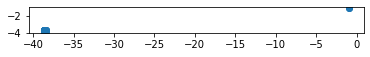

In [ ]:
gdf = gpd.GeoDataFrame(
    result, geometry=gpd.points_from_xy(result.NR_LONGITUDE, result.NR_LATITUDE), crs='EPSG:4326')
gdf.plot()

Oxe. Parece que temos uma ou mais coordenadas erradas.

In [ ]:
result.sort_values('NR_LONGITUDE')

,NM_LOCAL_VOTACAO,NR_LATITUDE,NR_LONGITUDE,LULA,BOLSONARO,QT_VOTOS_VALIDOS,geometry
251,EM JOAO MENDES DE ANDRADE,-3.789092,-38.629248,178,80,258,POINT (-38.62925 -3.78909)
234,EM DOM LUSTOSA,-3.784367,-38.626658,385,282,667,POINT (-38.62666 -3.78437)
279,EM PROF ANTONIA MARIA DE LIMA,-3.790407,-38.624857,174,134,308,POINT (-38.62486 -3.79041)
294,EM RACHEL VIANA MARTINS,-3.792712,-38.624605,407,223,630,POINT (-38.62461 -3.79271)
383,ESCOLA MUNICIPAL PROF JOSE CÍRIO PEREIRA FILHO,-3.805497,-38.623029,174,118,292,POINT (-38.62303 -3.80550)
...,...,...,...,...,...,...,...
293,EM PROFª FERNANDA MARIA DE ALENCAR COLARES,-3.819970,-38.451752,592,402,994,POINT (-38.45175 -3.81997)
290,EM PROFESSORA JOSEFINA PARENTE DE ARAÚJO,-3.800609,-38.449514,349,174,523,POINT (-38.44951 -3.80061)
393,ETI MARIA ODETE DA SILVA COLARES,-1.000000,-1.000000,142,115,257,POINT (-1.00000 -1.00000)
119,COLÉGIO VIDA VIVA,-1.000000,-1.000000,353,261,614,POINT (-1.00000 -1.00000)


Alguns locais não têm coordenadas válidas. Vamos ver quais são e corrigir isso.

### Inserindo coordenadas faltantes

In [ ]:
result[result['NR_LATITUDE'] > -2]

,NM_LOCAL_VOTACAO,NR_LATITUDE,NR_LONGITUDE,LULA,BOLSONARO,QT_VOTOS_VALIDOS,geometry
119,COLÉGIO VIDA VIVA,-1.0,-1.0,353,261,614,POINT (-1.00000 -1.00000)
393,ETI MARIA ODETE DA SILVA COLARES,-1.0,-1.0,142,115,257,POINT (-1.00000 -1.00000)


Pesquisei no Google Maps e cheguei a essas coordenadas.

In [ ]:
coords = {
    'COLÉGIO VIDA VIVA': (-3.8179826,-38.62258 ),
    'CRECHE RACHEL GUIMARÃES MARTINS BARBOSA': (-3.7228782,-38.4750446),
    'ETI MARIA ODETE DA SILVA COLARES': (-3.822735,-38.4894616), # Usei info Google Maps
}

for index in result[result['NR_LATITUDE'] == -1.0].index:
    result.loc[index, 'NR_LATITUDE'] = coords[result.loc[index, 'NM_LOCAL_VOTACAO']][0]
    result.loc[index, 'NR_LONGITUDE'] = coords[result.loc[index, 'NM_LOCAL_VOTACAO']][1]

In [ ]:
gdf = gpd.GeoDataFrame(
    result, geometry=gpd.points_from_xy(result.NR_LONGITUDE, result.NR_LATITUDE), crs='EPSG:4326')

In [ ]:
gdf = gdf.to_crs('EPSG:31985')

Vamos plotar e ver se deu certo.

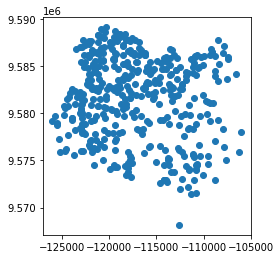

In [ ]:
gdf.plot()

Conheço essa cidade rs. Vamos ver com a base de bairros que carregamos anteriormente.

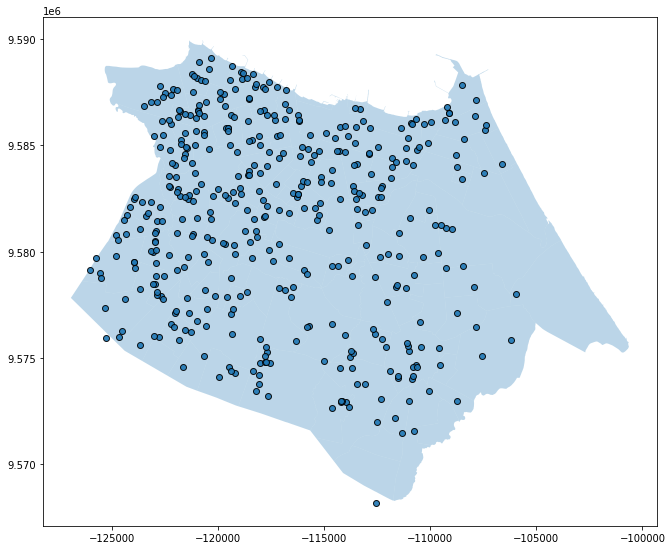

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(11,11))
bairros.plot(ax=ax, alpha=0.3, zorder=1)
gdf.plot(ax=ax, alpha=0.9, edgecolor='k', zorder=2)

### Mapa dos locais de votação segundo candidato com melhor desempenho

A ideia é ver onde cada candidato se saiu melhor.

In [ ]:
import folium

In [ ]:
gdf = gdf[gdf['NM_LOCAL_VOTACAO'] != 'NÃO IDENTIFICADO']
gdf

,NM_LOCAL_VOTACAO,NR_LATITUDE,NR_LONGITUDE,LULA,BOLSONARO,QT_VOTOS_VALIDOS,geometry
0,ACADEMIA DO PROFESSOR DARCY RIBEIRO,-3.732985,-38.519954,289,224,513,POINT (-113886.875 9585457.358)
1,ANEXO EEFM ALMIRANTE TAMANDARÉ,-3.838474,-38.516635,374,301,675,POINT (-113441.873 9573745.221)
2,ANTIGA FIC / ESTÁCIO MOREIRA CAMPOS,-3.742608,-38.501558,250,260,510,POINT (-111827.908 9584401.627)
3,APAE - CENTRO DE ATENDIMENTO EDUC ESPEC MA REG...,-3.739336,-38.523871,391,340,731,POINT (-114319.304 9584749.267)
4,ASSEMBLÉIA LEGISLATIVA - UNIVERSIDADE DO PARLA...,-3.750829,-38.501984,142,128,270,POINT (-111869.694 9583488.414)
...,...,...,...,...,...,...,...
429,SENAI - CENTRO DE FORMAÇÃO PROFISSIONAL,-3.707215,-38.584885,165,118,283,POINT (-121148.895 9588273.449)
430,SENAI - UNIDADE JACARECANGA,-3.726382,-38.540661,268,171,439,POINT (-116201.470 9586176.051)
431,UNIFAMETRO - CAMPUS PADRE IBIAPINA,-3.726022,-38.540487,120,86,206,POINT (-116182.357 9586216.166)
432,UNIVERSIDADE DE FORTALEZA - UNIFOR,-3.771319,-38.480984,437,353,790,POINT (-109512.884 9581227.916)


In [ ]:
m = folium.Map(
    location=[-3.7756226, -38.53197959], #Coordenadas Gerais de Fortaleza-Ce
    zoom_start=12, 
    tiles='cartodbpositron',
    control_scale=True
)

def get_color(label):
    color = {
        "LULA_GANHOU": '#FF0000',
        "LULA_GANHOU_MAIS_55": '#8B0000',
        "BOLSONARO_GANHOU": '#22ff18',
        "BOLSONARO_GANHOU_MAIS_55": '#007819',
        "EMPATE": '#ffb30a'
    }
    return color[label]

def get_label(index):
    label = 'ERRO'
    lula, bolsonaro, total = gdf.loc[index, 'LULA'], gdf.loc[index, 'BOLSONARO'], \
        gdf.loc[index, 'QT_VOTOS_VALIDOS']
    sorted_values = sorted([lula, bolsonaro], reverse=True)
    if sorted_values[0] == sorted_values[1]:
        label = 'EMPATE'
    elif lula == sorted_values[0]:
        label = 'LULA_GANHOU'
        if lula / total > 0.55:
            label = 'LULA_GANHOU_MAIS_55'
    elif bolsonaro == sorted_values[0]:
        label = 'BOLSONARO_GANHOU'
        if bolsonaro / total > 0.55:
            label = 'BOLSONARO_GANHOU_MAIS_55'
    return label

def get_popup(index):
    lula, bolsonaro, total, nome_local = gdf.loc[index, 'LULA'], gdf.loc[index, 'BOLSONARO'], \
        gdf.loc[index, 'QT_VOTOS_VALIDOS'], gdf.loc[index, 'NM_LOCAL_VOTACAO']
    def percent(value):
        return "{0:.1%}".format(value/total)
    html_votos = f"""
        <p><b>Lula</b>: {lula} ({percent(lula)})</p>
        <p><b>Bolsonaro</b>: {bolsonaro} ({percent(bolsonaro)})</p>
        <p><b>Total</b>: {total}</p>
    """
    return f"""
        <div style='width:300px'>
            <p><b>{nome_local} - 2º TURNO</b></p>
            {html_votos}
        </div>
    """

for index in gdf.index:
    label = get_label(index)
    coords_location = gdf.loc[index, 'NR_LATITUDE'], gdf.loc[index, 'NR_LONGITUDE']
    folium.CircleMarker(
        coords_location, 
        radius=7, 
        color='#FFF',
        fill_color=get_color(label),
        fill_opacity=1,
        popup=get_popup(index),
        weight=2
    ).add_to(m)

### Mapa final

Pontos em tons verdes onde Bolsonaro venceu. Pontos em tons vermelhos onde Lula venceu. Quando a cor é mais escura, significa que o candidato obteve mais de 55% dos votos válidos. A cor laranja representa empate.

In [ ]:
m
